In [106]:
import pandas as pd
import matplotlib.pyplot as plt

#log = 'logs/recovery-data.csv'
#log = 'logs/Sensor_data_100Hz_2.csv'
#log_type = 'simcon'

log = 'logs/recovery-data.csv'
log_type = 'rec'

sensor_mapper = {'f9c9f80b-679c-41ba-a720-1d9d7fd54d4f': 'acc_z_0',
                 '1ec96258-c5b0-4ace-b138-d4b6ebb94077': 'acc_z_0',
                 '54f15804-28c3-4b22-82df-d95b40b9a3d2': 'acc_z_1',
                 '294906ee-7119-43a0-8b2d-960a8b5b3d34': 'acc_z_1',
                 'cc6a95a0-bfd3-4cb0-88b8-00ad2bfbdd33': 'acc_z_2',
                 '22752219-cefa-4fea-8cbb-590e90be031b': 'acc_z_2',
                 'a2cd99cf-32eb-47f0-845d-6b7d3515d298': 'baro_0',
                 '21bc6e03-949d-4895-bdc5-3813f477c650': 'baro_0',
                 'ff1f6c69-0601-49a0-9bf8-11b0082debd7': 'baro_1',
                 '3c25aa65-242d-4527-b812-75d7b481ee66': 'baro_1',
                 'e99c3424-957e-4c60-a8f8-821857457f32': 'baro_2',
                 '5e32df81-1a9f-4453-973c-42dc35df8763': 'baro_2',
                 'f03e12b2-39f3-4039-b72b-3cfd3273083c': 'temp_0',
                 'cd4c5737-afe1-4d57-8744-e9d47648f074': 'temp_0',
                 '7511b0fa-77ab-4ed8-8e20-11fa19c1ad84': 'temp_1',
                 'eab2f675-3fc2-40ce-a371-b1a2ea1c9c7d': 'temp_1',
                 'c3f011cf-9229-4dc2-904b-0f6a3e2fdf2b': 'temp_2',
                 '94e18422-443a-46a7-9bfc-476da6236470': 'temp_2',}

rec_col_mapper = {'Ay_IMU1': 'acc_z_0',
                  'Ay_IMU2': 'acc_z_1',
                  'P_BARO1': 'baro_0',
                  'P_BARO2': 'baro_1',
                  'T_BARO1': 'temp_0',
                  'T_BARO2': 'temp_1',}

if log_type == 'simcon':
    log_df = pd.read_csv(log, index_col = 0, converters = {'t': lambda x: float(x) * 1000, # convert to milliseconds
                                                           'flight_sensor_id': lambda x: sensor_mapper[x],
                                                           'value': lambda x: x.strip('[]')})
    log_df = log_df.pivot(index='t', columns='flight_sensor_id', values='value')
    log_df.index = log_df.index - log_df.index.min()  #set first t to 0
    #log_df.head()
else:
    log_df = pd.read_csv(log, index_col = 0, usecols = ['Time', 'T_BARO1', 'T_BARO2', 'P_BARO1', 'P_BARO2', 'Ay_IMU1', 'Ay_IMU2'])
    log_df.index.name = 't'
    log_df = log_df.rename(columns = rec_col_mapper)
    log_df.index = log_df.index - log_df.index.min()  #set first t to 0
    
for timestamp, sensor_readings in log_df.iterrows():
    b = float(sensor_readings["temp_0"])
    print(b)

22.07
22.11
22.11
22.14
22.14
22.17
22.14
22.16
22.16
22.18
22.18
22.18
22.19
22.2
22.21
22.21
22.2
22.2
22.21
22.21
22.23
22.22
22.24
22.22
22.24
22.22
22.23
22.24
22.24
22.23
22.26
22.24
22.24
22.25
22.25
22.22
22.25
22.26
22.25
22.26
22.26
22.27
22.26
22.26
22.25
22.29
22.27
22.29
22.25
22.27
22.27
22.28
22.26
22.28
22.28
22.25
22.27
22.26
22.27
22.27
22.29
22.28
22.28
22.27
22.27
22.28
22.3
22.28
22.28
22.27
22.3
22.28
22.29
22.29
22.29
22.28
22.28
22.27
22.27
22.3
22.28
22.29
22.29
22.28
22.27
22.28
22.27
22.26
22.28
22.29
22.27
22.28
22.27
22.3
22.3
22.28
22.31
22.29
22.29
22.3
22.27
22.27
22.27
22.29
22.31
22.3
22.28
22.29
22.28
22.31
22.3
22.28
22.26
22.3
22.3
22.29
22.31
22.28
22.29
22.3
22.3
22.31
22.31
22.28
22.28
22.29
22.28
22.31
22.32
22.29
22.29
22.29
22.3
22.29
22.28
22.29
22.29
22.32
22.27
22.3
22.3
22.32
22.3
22.29
22.32
22.29
22.3
22.3
22.31
22.28
22.29
22.29
22.31
22.3
22.31
22.29
22.32
22.31
22.29
22.31
22.28
22.29
22.32
22.31
22.29
22.32
22.3
22.31
22.32
22.3
22.3

22.87
22.86
22.87
22.86
22.85
22.86
22.87
22.86
22.85
22.83
22.85
22.87
22.86
22.85
22.85
22.85
22.85
22.83
22.84
22.82
22.87
22.84
22.87
22.85
22.85
22.87
22.85
22.84
22.87
22.88
22.88
22.86
22.87
22.86
22.87
22.86
22.86
22.87
22.86
22.86
22.87
22.87
22.87
22.86
22.87
22.88
22.86
22.88
22.88
22.86
22.87
22.86
22.88
22.87
22.86
22.87
22.87
22.86
22.88
22.86
22.87
22.87
22.88
22.89
22.89
22.87
22.88
22.88
22.89
22.87
22.87
22.86
22.87
22.87
22.9
22.89
22.89
22.91
22.87
22.9
22.86
22.88
22.89
22.9
22.88
22.91
22.89
22.89
22.88
22.89
22.89
22.9
22.87
22.86
22.9
22.87
22.89
22.9
22.9
22.86
22.9
22.88
22.87
22.89
22.89
22.88
22.88
22.89
22.89
22.89
22.9
22.88
22.9
22.89
22.9
22.89
22.89
22.91
22.91
22.88
22.9
22.9
22.89
22.91
22.92
22.89
22.9
22.91
22.9
22.9
22.92
22.89
22.9
22.89
22.91
22.9
22.92
22.91
22.91
22.91
22.91
22.92
22.91
22.92
22.88
22.92
22.92
22.92
22.91
22.93
22.92
22.94
22.91
22.89
22.9
22.92
22.93
22.9
22.93
22.9
22.91
22.94
22.91
22.91
22.91
22.93
22.93
22.92
22.92
22.92
2

23.44
23.42
23.41
23.42
23.4
23.43
23.42
23.42
23.43
23.43
23.44
23.43
23.41
23.41
23.42
23.42
23.43
23.41
23.41
23.43
23.42
23.44
23.41
23.43
23.43
23.43
23.43
23.42
23.42
23.42
23.44
23.45
23.44
23.43
23.44
23.44
23.44
23.44
23.42
23.45
23.41
23.45
23.43
23.44
23.43
23.43
23.45
23.43
23.44
23.44
23.45
23.45
23.43
23.44
23.44
23.44
23.43
23.44
23.45
23.44
23.43
23.44
23.45
23.44
23.44
23.44
23.44
23.44
23.45
23.45
23.44
23.44
23.46
23.43
23.42
23.43
23.45
23.42
23.43
23.43
23.45
23.43
23.45
23.44
23.45
23.43
23.44
23.45
23.45
23.44
23.45
23.44
23.44
23.46
23.45
23.46
23.45
23.44
23.45
23.45
23.44
23.44
23.46
23.46
23.45
23.43
23.44
23.44
23.46
23.44
23.45
23.48
23.44
23.45
23.45
23.45
23.45
23.46
23.45
23.47
23.46
23.45
23.45
23.47
23.48
23.46
23.47
23.46
23.46
23.48
23.46
23.45
23.47
23.47
23.47
23.45
23.47
23.45
23.47
23.46
23.46
23.46
23.45
23.48
23.47
23.44
23.48
23.44
23.45
23.46
23.45
23.45
23.47
23.46
23.44
23.49
23.48
23.47
23.46
23.48
23.46
23.46
23.47
23.47
23.45
23.47
23.46

23.85
23.87
23.89
23.87
23.87
23.87
23.87
23.87
23.87
23.88
23.88
23.86
23.86
23.84
23.86
23.85
23.86
23.85
23.84
23.88
23.87
23.88
23.87
23.88
23.88
23.86
23.87
23.87
23.86
23.86
23.88
23.86
23.88
23.88
23.88
23.89
23.89
23.88
23.89
23.89
23.9
23.88
23.86
23.89
23.88
23.89
23.89
23.86
23.9
23.89
23.88
23.85
23.89
23.88
23.87
23.88
23.89
23.9
23.9
23.87
23.89
23.88
23.89
23.88
23.88
23.88
23.89
23.88
23.89
23.86
23.88
23.88
23.88
23.9
23.89
23.9
23.89
23.88
23.89
23.88
23.89
23.9
23.9
23.88
23.88
23.9
23.89
23.9
23.89
23.9
23.9
23.89
23.88
23.91
23.89
23.9
23.89
23.9
23.87
23.91
23.89
23.88
23.9
23.89
23.89
23.91
23.89
23.89
23.9
23.9
23.9
23.89
23.92
23.93
23.91
23.9
23.91
23.9
23.91
23.91
23.93
23.92
23.9
23.91
23.9
23.91
23.93
23.91
23.9
23.9
23.91
23.89
23.91
23.91
23.91
23.89
23.91
23.88
23.91
23.91
23.9
23.91
23.91
23.94
23.9
23.89
23.91
23.9
23.88
23.89
23.89
23.89
23.91
23.9
23.92
23.92
23.92
23.92
23.91
23.91
23.92
23.9
23.92
23.93
23.92
23.9
23.91
23.91
23.94
23.91
23.91
23.9

24.24
24.21
24.24
24.23
24.22
24.2
24.22
24.22
24.22
24.22
24.22
24.24
24.21
24.21
24.23
24.22
24.24
24.21
24.22
24.23
24.22
24.22
24.22
24.24
24.23
24.22
24.22
24.23
24.23
24.21
24.23
24.23
24.23
24.24
24.23
24.23
24.24
24.23
24.23
24.24
24.22
24.23
24.25
24.23
24.24
24.23
24.23
24.23
24.23
24.23
24.23
24.22
24.22
24.21
24.23
24.23
24.2
24.22
24.23
24.23
24.23
24.22
24.22
24.23
24.24
24.23
24.23
24.22
24.21
24.23
24.23
24.24
24.22
24.23
24.22
24.21
24.22
24.23
24.22
24.24
24.22
24.24
24.25
24.23
24.22
24.23
24.21
24.22
24.25
24.22
24.24
24.23
24.23
24.23
24.23
24.21
24.25
24.23
24.23
24.24
24.22
24.24
24.22
24.23
24.23
24.23
24.24
24.21
24.23
24.23
24.24
24.25
24.24
24.24
24.25
24.23
24.25
24.26
24.23
24.26
24.22
24.23
24.25
24.23
24.24
24.22
24.24
24.25
24.25
24.24
24.24
24.25
24.26
24.25
24.25
24.25
24.27
24.23
24.25
24.23
24.24
24.22
24.24
24.26
24.23
24.24
24.22
24.24
24.25
24.25
24.24
24.23
24.26
24.25
24.27
24.25
24.28
24.24
24.25
24.24
24.23
24.24
24.26
24.25
24.25
24.23
24.27


24.5
24.52
24.52
24.52
24.52
24.51
24.53
24.52
24.52
24.51
24.52
24.49
24.51
24.49
24.52
24.53
24.5
24.52
24.52
24.52
24.51
24.5
24.52
24.52
24.52
24.51
24.51
24.53
24.52
24.52
24.54
24.51
24.52
24.53
24.5
24.51
24.5
24.51
24.49
24.52
24.5
24.52
24.51
24.51
24.51
24.53
24.5
24.53
24.51
24.53
24.53
24.53
24.52
24.53
24.51
24.51
24.51
24.53
24.54
24.5
24.5
24.51
24.53
24.53
24.56
24.52
24.51
24.54
24.52
24.5
24.53
24.52
24.5
24.52
24.52
24.52
24.51
24.52
24.51
24.52
24.48
24.53
24.51
24.54
24.53
24.53
24.53
24.54
24.52
24.54
24.53
24.54
24.52
24.53
24.54
24.53
24.54
24.53
24.53
24.51
24.52
24.53
24.54
24.53
24.52
24.52
24.52
24.51
24.52
24.54
24.53
24.53
24.53
24.56
24.54
24.51
24.53
24.55
24.51
24.52
24.53
24.51
24.54
24.54
24.53
24.53
24.51
24.53
24.51
24.56
24.55
24.52
24.54
24.56
24.53
24.54
24.53
24.54
24.53
24.52
24.52
24.55
24.53
24.55
24.53
24.53
24.52
24.54
24.56
24.52
24.56
24.53
24.54
24.53
24.54
24.54
24.54
24.56
24.55
24.52
24.54
24.56
24.52
24.53
24.55
24.55
24.55
24.55
24.

24.78
24.79
24.79
24.8
24.79
24.79
24.81
24.79
24.77
24.78
24.78
24.8
24.78
24.79
24.8
24.77
24.77
24.79
24.77
24.76
24.78
24.79
24.78
24.8
24.79
24.79
24.79
24.78
24.81
24.79
24.79
24.79
24.79
24.8
24.78
24.82
24.8
24.8
24.81
24.81
24.81
24.81
24.82
24.82
24.81
24.8
24.79
24.78
24.81
24.81
24.82
24.79
24.78
24.79
24.78
24.77
24.79
24.79
24.8
24.79
24.8
24.81
24.8
24.81
24.82
24.77
24.81
24.79
24.82
24.8
24.82
24.77
24.81
24.79
24.79
24.81
24.82
24.79
24.82
24.79
24.81
24.79
24.83
24.81
24.82
24.81
24.82
24.82
24.82
24.79
24.81
24.82
24.83
24.78
24.78
24.82
24.8
24.82
24.79
24.83
24.8
24.81
24.79
24.81
24.81
24.81
24.81
24.81
24.81
24.8
24.83
24.81
24.81
24.8
24.83
24.79
24.81
24.81
24.83
24.81
24.79
24.81
24.8
24.83
24.82
24.8
24.83
24.81
24.81
24.8
24.81
24.82
24.8
24.81
24.8
24.8
24.82
24.82
24.81
24.82
24.81
24.84
24.8
24.81
24.81
24.81
24.81
24.81
24.84
24.82
24.83
24.8
24.81
24.8
24.8
24.8
24.79
24.8
24.84
24.79
24.8
24.82
24.81
24.79
24.8
24.81
24.77
24.83
24.81
24.8
24.82
24.81

25.05
25.05
25.05
25.06
25.04
25.06
25.07
25.05
25.04
25.03
25.04
25.05
25.05
25.03
25.03
25.04
25.03
25.04
25.02
25.05
25.03
25.04
25.06
25.04
25.06
25.05
25.05
25.07
25.04
25.06
25.05
25.05
25.05
25.05
25.06
25.06
25.08
25.06
25.03
25.08
25.05
25.06
25.06
25.05
25.06
25.06
25.04
25.06
25.04
25.05
25.06
25.06
25.07
25.06
25.05
25.06
25.05
25.07
25.07
25.07
25.07
25.07
25.07
25.05
25.05
25.04
25.05
25.06
25.05
25.06
25.07
25.06
25.07
25.04
25.04
25.07
25.07
25.06
25.05
25.08
25.06
25.07
25.03
25.04
25.05
25.05
25.07
25.06
25.05
25.07
25.06
25.05
25.07
25.07
25.07
25.07
25.04
25.05
25.08
25.07
25.07
25.06
25.07
25.06
25.06
25.07
25.07
25.06
25.08
25.04
25.08
25.08
25.07
25.07
25.06
25.08
25.06
25.03
25.06
25.04
25.05
25.07
25.07
25.09
25.09
25.07
25.07
25.06
25.08
25.06
25.06
25.06
25.07
25.07
25.04
25.07
25.08
25.08
25.07
25.06
25.08
25.08
25.06
25.08
25.09
25.05
25.05
25.08
25.06
25.07
25.08
25.09
25.04
25.09
25.07
25.07
25.08
25.07
25.07
25.07
25.06
25.07
25.07
25.05
25.09
25.08
25.0

25.28
25.28
25.29
25.29
25.29
25.32
25.27
25.29
25.32
25.28
25.28
25.3
25.29
25.26
25.28
25.26
25.3
25.31
25.3
25.3
25.29
25.32
25.27
25.27
25.3
25.31
25.3
25.3
25.32
25.28
25.29
25.3
25.3
25.31
25.3
25.3
25.31
25.3
25.29
25.31
25.3
25.29
25.3
25.3
25.31
25.32
25.31
25.31
25.29
25.3
25.31
25.29
25.29
25.29
25.32
25.29
25.33
25.31
25.31
25.31
25.31
25.31
25.31
25.31
25.32
25.29
25.32
25.31
25.34
25.31
25.31
25.31
25.3
25.31
25.32
25.33
25.33
25.31
25.32
25.32
25.33
25.33
25.31
25.3
25.33
25.31
25.32
25.31
25.32
25.32
25.33
25.32
25.3
25.31
25.3
25.31
25.32
25.3
25.31
25.29
25.33
25.32
25.32
25.32
25.31
25.32
25.31
25.33
25.31
25.31
25.32
25.32
25.31
25.32
25.33
25.32
25.31
25.31
25.3
25.31
25.3
25.29
25.32
25.33
25.32
25.31
25.3
25.31
25.29
25.31
25.32
25.31
25.31
25.32
25.3
25.31
25.32
25.31
25.32
25.3
25.32
25.31
25.32
25.31
25.29
25.32
25.32
25.32
25.3
25.3
25.29
25.32
25.3
25.32
25.32
25.32
25.33
25.29
25.31
25.31
25.3
25.32
25.31
25.3
25.32
25.32
25.32
25.33
25.31
25.3
25.31
25.33


25.5
25.48
25.49
25.49
25.47
25.48
25.49
25.47
25.48
25.45
25.5
25.48
25.47
25.48
25.48
25.47
25.5
25.46
25.51
25.46
25.49
25.48
25.49
25.46
25.48
25.5
25.49
25.47
25.47
25.48
25.51
25.48
25.48
25.48
25.48
25.5
25.46
25.48
25.47
25.5
25.48
25.48
25.49
25.52
25.49
25.51
25.51
25.48
25.49
25.49
25.48
25.48
25.51
25.48
25.5
25.5
25.48
25.51
25.49
25.5
25.5
25.5
25.49
25.51
25.48
25.49
25.49
25.51
25.5
25.5
25.5
25.5
25.51
25.48
25.49
25.5
25.5
25.51
25.5
25.48
25.49
25.49
25.49
25.5
25.49
25.51
25.49
25.51
25.54
25.49
25.49
25.5
25.49
25.52
25.49
25.48
25.49
25.5
25.5
25.48
25.5
25.51
25.48
25.49
25.49
25.51
25.5
25.5
25.51
25.52
25.47
25.51
25.52
25.49
25.5
25.51
25.51
25.52
25.52
25.5
25.48
25.52
25.51
25.51
25.51
25.49
25.5
25.52
25.5
25.51
25.49
25.49
25.5
25.51
25.51
25.49
25.52
25.53
25.48
25.51
25.5
25.51
25.49
25.51
25.52
25.53
25.51
25.52
25.49
25.51
25.52
25.5
25.51
25.51
25.5
25.51
25.5
25.47
25.51
25.49
25.5
25.51
25.51
25.5
25.5
25.52
25.51
25.52
25.5
25.49
25.5
25.51
25.54
2

25.67
25.65
25.67
25.67
25.67
25.67
25.67
25.66
25.67
25.67
25.67
25.67
25.67
25.67
25.67
25.68
25.67
25.68
25.67
25.68
25.66
25.68
25.66
25.66
25.67
25.67
25.66
25.7
25.66
25.68
25.68
25.69
25.66
25.67
25.68
25.68
25.68
25.67
25.69
25.66
25.65
25.67
25.68
25.68
25.66
25.68
25.67
25.66
25.67
25.7
25.68
25.66
25.68
25.66
25.68
25.7
25.69
25.68
25.69
25.69
25.68
25.68
25.69
25.69
25.68
25.66
25.66
25.67
25.67
25.66
25.69
25.7
25.68
25.69
25.68
25.69
25.69
25.68
25.67
25.68
25.69
25.67
25.68
25.68
25.68
25.7
25.7
25.68
25.69
25.69
25.68
25.69
25.68
25.68
25.71
25.69
25.69
25.68
25.71
25.67
25.7
25.69
25.69
25.68
25.69
25.67
25.7
25.68
25.67
25.67
25.71
25.67
25.69
25.69
25.7
25.66
25.71
25.69
25.65
25.66
25.66
25.69
25.67
25.7
25.67
25.67
25.67
25.69
25.7
25.68
25.67
25.7
25.67
25.68
25.66
25.71
25.7
25.68
25.68
25.7
25.69
25.68
25.69
25.7
25.69
25.7
25.65
25.69
25.7
25.72
25.69
25.69
25.68
25.69
25.7
25.68
25.7
25.7
25.7
25.69
25.69
25.7
25.69
25.68
25.72
25.67
25.69
25.68
25.69
25.69
25

25.82
25.82
25.8
25.84
25.82
25.83
25.8
25.82
25.82
25.82
25.81
25.84
25.81
25.84
25.83
25.82
25.83
25.83
25.79
25.82
25.83
25.81
25.81
25.8
25.82
25.81
25.83
25.82
25.83
25.8
25.8
25.82
25.83
25.82
25.82
25.82
25.83
25.82
25.81
25.83
25.82
25.82
25.83
25.82
25.83
25.84
25.83
25.83
25.83
25.84
25.83
25.83
25.82
25.83
25.81
25.82
25.83
25.8
25.84
25.84
25.81
25.82
25.8
25.83
25.81
25.84
25.82
25.85
25.8
25.83
25.82
25.82
25.83
25.82
25.82
25.83
25.83
25.81
25.82
25.83
25.82
25.83
25.81
25.82
25.83
25.82
25.82
25.82
25.8
25.84
25.83
25.84
25.84
25.83
25.82
25.83
25.85
25.82
25.86
25.84
25.85
25.83
25.84
25.84
25.84
25.84
25.84
25.84
25.82
25.84
25.83
25.83
25.86
25.84
25.83
25.83
25.84
25.84
25.85
25.85
25.83
25.84
25.84
25.84
25.83
25.84
25.83
25.86
25.83
25.85
25.83
25.85
25.82
25.85
25.83
25.86
25.85
25.84
25.86
25.81
25.82
25.85
25.85
25.85
25.85
25.84
25.84
25.83
25.85
25.86
25.83
25.86
25.85
25.85
25.84
25.83
25.84
25.82
25.85
25.84
25.86
25.85
25.85
25.85
25.85
25.83
25.85
25.84
2

26.04
26.03
26.04
26.04
26.03
26.04
26.03
26.03
26.04
26.02
26.03
26.04
26.02
26.04
26.02
26.05
26.01
26.02
26.01
26.03
26.01
26.02
26.04
26.05
26.02
26.04
26.03
26.0
26.07
26.05
26.02
26.03
26.03
26.03
26.03
26.05
26.02
26.04
26.05
26.01
26.03
26.03
26.03
26.03
26.04
26.01
26.03
26.06
26.03
26.03
26.05
26.04
26.02
26.07
26.04
26.0
26.05
26.04
26.02
26.02
26.02
26.02
26.05
26.02
26.02
26.02
26.04
26.0
26.01
26.02
25.99
26.01
26.01
26.02
26.05
26.03
26.01
26.01
26.02
26.02
26.01
26.03
26.03
26.01
26.04
26.03
26.05
26.05
26.0
26.04
26.02
26.04
26.05
26.05
26.02
26.05
26.04
26.08
26.06
26.01
26.03
26.01
26.04
26.01
26.04
26.04
26.01
26.04
26.06
26.04
26.05
26.02
26.03
26.04
26.02
26.03
26.04
26.06
26.05
26.02
26.02
26.04
26.05
26.04
26.04
26.03
26.04
26.05
26.05
26.05
26.01
26.05
26.03
26.04
26.03
26.04
26.06
26.07
26.04
26.04
26.04
26.06
26.05
26.05
26.04
26.04
26.06
26.05
26.04
26.05
26.04
26.06
26.05
26.03
26.04
26.05
26.06
26.05
26.06
26.04
26.05
26.06
26.05
26.05
26.06
26.05
26.05
26

26.17
26.18
26.16
26.16
26.15
26.14
26.16
26.16
26.16
26.18
26.2
26.16
26.15
26.16
26.18
26.18
26.15
26.16
26.15
26.16
26.15
26.16
26.16
26.14
26.15
26.17
26.14
26.17
26.15
26.18
26.17
26.15
26.18
26.15
26.15
26.16
26.17
26.16
26.14
26.16
26.15
26.17
26.15
26.15
26.14
26.14
26.16
26.17
26.16
26.15
26.17
26.16
26.14
26.14
26.17
26.13
26.16
26.15
26.16
26.18
26.16
26.17
26.16
26.15
26.17
26.16
26.15
26.15
26.17
26.17
26.17
26.18
26.15
26.16
26.16
26.16
26.16
26.15
26.16
26.18
26.16
26.17
26.14
26.16
26.16
26.15
26.13
26.16
26.16
26.16
26.15
26.16
26.14
26.13
26.16
26.14
26.17
26.15
26.13
26.17
26.16
26.14
26.15
26.13
26.16
26.14
26.15
26.17
26.14
26.14
26.17
26.17
26.17
26.16
26.14
26.17
26.16
26.19
26.16
26.19
26.14
26.16
26.19
26.16
26.17
26.19
26.15
26.16
26.17
26.16
26.16
26.16
26.16
26.16
26.16
26.2
26.18
26.15
26.16
26.17
26.17
26.17
26.16
26.16
26.15
26.15
26.17
26.17
26.17
26.16
26.16
26.15
26.18
26.16
26.17
26.18
26.14
26.17
26.13
26.17
26.17
26.18
26.15
26.16
26.16
26.17
26.18


26.12
26.13
26.11
26.13
26.14
26.13
26.12
26.09
26.1
26.1
26.15
26.12
26.13
26.12
26.11
26.14
26.13
26.13
26.12
26.15
26.11
26.14
26.15
26.11
26.12
26.11
26.12
26.12
26.13
26.13
26.14
26.1
26.1
26.11
26.1
26.11
26.11
26.13
26.13
26.12
26.11
26.13
26.11
26.11
26.12
26.13
26.13
26.12
26.1
26.14
26.11
26.1
26.14
26.12
26.13
26.13
26.12
26.11
26.11
26.1
26.11
26.09
26.1
26.11
26.11
26.12
26.12
26.11
26.11
26.09
26.14
26.12
26.13
26.11
26.12
26.11
26.13
26.11
26.11
26.11
26.12
26.11
26.09
26.11
26.11
26.1
26.11
26.12
26.13
26.12
26.15
26.11
26.13
26.1
26.12
26.12
26.12
26.09
26.1
26.12
26.11
26.13
26.13
26.1
26.13
26.12
26.13
26.13
26.11
26.12
26.11
26.11
26.14
26.12
26.11
26.1
26.13
26.09
26.12
26.12
26.11
26.14
26.11
26.13
26.12
26.14
26.1
26.11
26.1
26.12
26.12
26.1
26.13
26.12
26.12
26.1
26.11
26.12
26.12
26.11
26.11
26.11
26.12
26.12
26.13
26.11
26.11
26.12
26.11
26.11
26.13
26.12
26.09
26.11
26.12
26.13
26.11
26.1
26.1
26.1
26.12
26.1
26.07
26.1
26.11
26.12
26.1
26.11
26.11
26.1
26.11

25.99
26.0
25.99
26.01
25.99
25.98
25.98
26.0
26.0
25.96
26.01
25.96
25.99
26.0
26.0
25.96
25.98
25.98
25.99
25.99
25.99
25.97
25.99
25.98
25.99
25.99
25.98
26.0
25.97
25.98
25.97
25.98
25.98
25.99
25.98
25.98
25.98
25.99
25.96
26.01
25.96
25.99
25.98
25.99
26.01
25.98
25.97
26.0
25.98
25.99
25.98
26.0
25.99
25.97
25.98
25.99
25.97
26.0
25.98
25.98
25.98
25.98
25.98
25.97
25.99
25.95
25.98
25.97
25.98
25.98
25.99
25.98
25.99
25.99
25.98
25.99
25.99
26.0
25.97
25.97
25.98
25.98
26.0
26.0
26.01
25.98
26.0
25.99
25.96
25.98
25.99
25.99
25.97
25.98
25.97
25.96
25.97
25.96
25.99
25.96
25.97
25.98
25.96
25.98
25.98
25.98
26.0
25.97
25.99
25.97
25.96
25.98
25.96
25.97
25.96
25.97
25.99
25.97
25.98
25.96
25.98
25.98
25.97
25.98
25.98
25.97
25.96
25.98
25.99
25.98
25.98
25.99
26.0
25.98
26.01
25.99
25.98
25.98
25.99
25.96
25.98
25.99
25.97
25.99
26.01
25.97
25.98
25.98
25.99
25.99
25.99
25.98
25.98
25.99
25.98
25.99
25.97
26.0
25.97
25.98
25.99
25.97
25.98
25.96
25.97
25.98
25.99
25.97
25.96
26

25.87
25.87
25.89
25.9
25.87
25.88
25.85
25.88
25.87
25.86
25.87
25.88
25.88
25.89
25.85
25.86
25.88
25.87
25.87
25.88
25.88
25.87
25.88
25.86
25.87
25.85
25.88
25.87
25.86
25.87
25.86
25.87
25.87
25.85
25.85
25.87
25.85
25.83
25.88
25.87
25.86
25.86
25.87
25.86
25.88
25.87
25.88
25.88
25.85
25.85
25.88
25.87
25.86
25.86
25.88
25.85
25.87
25.88
25.87
25.85
25.84
25.85
25.85
25.88
25.86
25.84
25.86
25.84
25.85
25.84
25.85
25.84
25.84
25.84
25.84
25.85
25.88
25.86
25.87
25.83
25.83
25.87
25.85
25.87
25.84
25.83
25.87
25.85
25.83
25.87
25.87
25.84
25.85
25.85
25.87
25.83
25.86
25.86
25.84
25.86
25.86
25.85
25.85
25.84
25.83
25.85
25.83
25.85
25.84
25.85
25.87
25.84
25.86
25.84
25.85
25.84
25.87
25.85
25.85
25.84
25.84
25.85
25.85
25.86
25.84
25.84
25.85
25.85
25.84
25.83
25.84
25.83
25.86
25.82
25.86
25.85
25.83
25.85
25.83
25.83
25.84
25.86
25.83
25.85
25.84
25.87
25.86
25.85
25.85
25.83
25.86
25.85
25.85
25.86
25.87
25.86
25.86
25.84
25.83
25.84
25.84
25.87
25.85
25.86
25.85
25.86
25.85

25.7
25.72
25.73
25.71
25.72
25.71
25.74
25.71
25.74
25.7
25.72
25.73
25.7
25.7
25.72
25.73
25.74
25.72
25.72
25.73
25.72
25.72
25.72
25.72
25.72
25.73
25.74
25.74
25.71
25.73
25.72
25.72
25.74
25.71
25.72
25.72
25.71
25.73
25.73
25.72
25.73
25.71
25.7
25.7
25.74
25.71
25.72
25.74
25.74
25.74
25.72
25.72
25.73
25.71
25.72
25.73
25.73
25.72
25.73
25.73
25.71
25.72
25.72
25.73
25.7
25.71
25.72
25.73
25.72
25.71
25.72
25.72
25.71
25.7
25.73
25.72
25.71
25.7
25.71
25.71
25.71
25.71
25.75
25.72
25.71
25.72
25.68
25.71
25.71
25.71
25.73
25.71
25.72
25.71
25.71
25.71
25.73
25.7
25.73
25.7
25.71
25.7
25.72
25.71
25.71
25.72
25.72
25.71
25.7
25.71
25.73
25.71
25.72
25.72
25.71
25.73
25.7
25.74
25.73
25.73
25.72
25.73
25.7
25.71
25.71
25.72
25.74
25.74
25.7
25.71
25.69
25.7
25.72
25.71
25.7
25.71
25.7
25.71
25.71
25.68
25.71
25.7
25.72
25.69
25.71
25.73
25.72
25.7
25.72
25.71
25.7
25.72
25.73
25.69
25.72
25.7
25.71
25.68
25.7
25.71
25.72
25.7
25.69
25.7
25.71
25.72
25.71
25.69
25.73
25.72
25.69


25.66
25.66
25.64
25.66
25.63
25.67
25.64
25.66
25.64
25.66
25.64
25.63
25.65
25.64
25.65
25.65
25.65
25.65
25.65
25.65
25.65
25.64
25.63
25.64
25.63
25.66
25.66
25.66
25.64
25.63
25.66
25.66
25.65
25.65
25.63
25.63
25.61
25.65
25.64
25.63
25.64
25.66
25.65
25.64
25.65
25.66
25.63
25.66
25.67
25.65
25.66
25.65
25.63
25.62
25.66
25.67
25.66
25.65
25.65
25.65
25.65
25.64
25.65
25.65
25.64
25.64
25.65
25.67
25.64
25.65
25.66
25.65
25.65
25.63
25.65
25.63
25.65
25.64
25.65
25.65
25.65
25.65
25.65
25.65
25.63
25.66
25.66
25.66
25.64
25.66
25.64
25.63
25.63
25.66
25.62
25.63
25.63
25.64
25.64
25.65
25.65
25.64
25.64
25.63
25.64
25.65
25.64
25.66
25.63
25.62
25.65
25.61
25.65
25.65
25.64
25.64
25.65
25.64
25.64
25.64
25.63
25.62
25.67
25.66
25.63
25.61
25.62
25.64
25.62
25.63
25.67
25.64
25.65
25.6
25.62
25.64
25.62
25.64
25.64
25.62
25.61
25.61
25.63
25.62
25.63
25.66
25.63
25.64
25.63
25.62
25.65
25.64
25.63
25.64
25.64
25.66
25.63
25.64
25.65
25.64
25.65
25.66
25.64
25.61
25.62
25.66
25.64

25.59
25.6
25.59
25.59
25.61
25.59
25.58
25.6
25.58
25.61
25.61
25.61
25.58
25.57
25.59
25.58
25.6
25.59
25.6
25.61
25.61
25.61
25.57
25.62
25.6
25.59
25.6
25.59
25.61
25.6
25.59
25.58
25.59
25.6
25.62
25.6
25.57
25.58
25.59
25.58
25.6
25.59
25.57
25.56
25.58
25.57
25.57
25.58
25.58
25.56
25.58
25.6
25.56
25.59
25.59
25.58
25.59
25.59
25.6
25.57
25.59
25.57
25.58
25.57
25.6
25.57
25.57
25.56
25.58
25.58
25.6
25.59
25.6
25.58
25.58
25.61
25.57
25.59
25.6
25.58
25.57
25.59
25.59
25.59
25.61
25.62
25.58
25.58
25.58
25.62
25.6
25.58
25.58
25.6
25.59
25.57
25.58
25.6
25.6
25.59
25.57
25.58
25.59
25.58
25.59
25.6
25.59
25.59
25.61
25.57
25.59
25.61
25.59
25.6
25.61
25.59
25.61
25.58
25.59
25.58
25.57
25.59
25.58
25.59
25.6
25.6
25.57
25.57
25.58
25.58
25.55
25.58
25.56
25.59
25.58
25.6
25.6
25.58
25.58
25.6
25.59
25.58
25.57
25.6
25.58
25.59
25.61
25.58
25.57
25.61
25.57
25.58
25.57
25.56
25.58
25.58
25.59
25.58
25.59
25.58
25.59
25.61
25.6
25.59
25.58
25.6
25.57
25.58
25.57
25.6
25.58
25.6


25.55
25.52
25.53
25.52
25.52
25.53
25.53
25.51
25.54
25.54
25.54
25.53
25.53
25.54
25.55
25.53
25.5
25.54
25.52
25.51
25.52
25.5
25.54
25.52
25.54
25.54
25.52
25.52
25.53
25.53
25.54
25.51
25.53
25.54
25.52
25.51
25.53
25.51
25.54
25.52
25.49
25.52
25.53
25.51
25.52
25.51
25.54
25.53
25.53
25.54
25.54
25.5
25.53
25.51
25.53
25.52
25.51
25.52
25.53
25.53
25.53
25.51
25.51
25.5
25.54
25.52
25.49
25.5
25.49
25.5
25.5
25.51
25.53
25.51
25.52
25.53
25.52
25.5
25.52
25.54
25.51
25.5
25.52
25.52
25.53
25.5
25.52
25.51
25.51
25.49
25.52
25.51
25.5
25.5
25.51
25.52
25.52
25.49
25.5
25.52
25.53
25.49
25.51
25.5
25.49
25.52
25.5
25.53
25.51
25.5
25.52
25.51
25.5
25.5
25.48
25.52
25.48
25.51
25.51
25.5
25.5
25.5
25.47
25.5
25.51
25.5
25.51
25.53
25.49
25.52
25.5
25.51
25.53
25.5
25.5
25.54
25.51
25.51
25.53
25.5
25.5
25.52
25.51
25.54
25.52
25.53
25.52
25.53
25.55
25.5
25.53
25.51
25.52
25.5
25.51
25.51
25.5
25.51
25.52
25.51
25.5
25.53
25.52
25.52
25.54
25.51
25.52
25.54
25.51
25.52
25.52
25.5
2

25.5
25.51
25.5
25.49
25.5
25.47
25.5
25.49
25.51
25.49
25.49
25.48
25.49
25.51
25.52
25.51
25.5
25.51
25.48
25.51
25.5
25.49
25.52
25.5
25.49
25.5
25.48
25.49
25.49
25.48
25.47
25.52
25.5
25.5
25.49
25.51
25.54
25.51
25.5
25.5
25.49
25.49
25.51
25.46
25.49
25.5
25.53
25.5
25.5
25.49
25.52
25.48
25.53
25.49
25.47
25.52
25.49
25.5
25.52
25.51
25.49
25.48
25.5
25.5
25.48
25.49
25.51
25.51
25.51
25.5
25.52
25.5
25.52
25.52
25.49
25.51
25.49
25.51
25.52
25.5
25.53
25.47
25.49
25.49
25.47
25.46
25.49
25.49
25.48
25.5
25.47
25.49
25.49
25.47
25.49
25.5
25.49
25.48
25.51
25.51
25.52
25.52
25.49
25.48
25.51
25.51
25.52
25.5
25.52
25.5
25.52
25.52
25.53
25.5
25.49
25.51
25.51
25.5
25.52
25.5
25.5
25.5
25.5
25.53
25.5
25.5
25.48
25.51
25.49
25.49
25.49
25.48
25.52
25.5
25.51
25.52
25.5
25.5
25.51
25.51
25.51
25.5
25.53
25.5
25.5
25.49
25.52
25.5
25.51
25.52
25.51
25.52
25.51
25.5
25.5
25.51
25.53
25.5
25.51
25.5
25.52
25.49
25.48
25.48
25.49
25.49
25.5
25.51
25.49
25.49
25.48
25.52
25.49
25.5
25

25.45
25.46
25.45
25.46
25.44
25.49
25.45
25.43
25.45
25.44
25.45
25.43
25.44
25.44
25.46
25.43
25.44
25.44
25.46
25.42
25.42
25.44
25.45
25.46
25.47
25.43
25.44
25.44
25.46
25.43
25.47
25.42
25.45
25.43
25.45
25.47
25.45
25.45
25.43
25.45
25.43
25.42
25.45
25.45
25.43
25.44
25.43
25.45
25.43
25.46
25.43
25.44
25.45
25.45
25.45
25.45
25.46
25.46
25.45
25.46
25.46
25.45
25.44
25.45
25.46
25.46
25.45
25.45
25.45
25.44
25.42
25.46
25.46
25.45
25.42
25.43
25.45
25.43
25.42
25.42
25.44
25.44
25.42
25.45
25.44
25.44
25.43
25.45
25.43
25.41
25.45
25.43
25.42
25.47
25.46
25.45
25.43
25.45
25.43
25.45
25.44
25.47
25.45
25.44
25.45
25.46
25.46
25.45
25.46
25.44
25.45
25.46
25.46
25.45
25.44
25.45
25.46
25.46
25.44
25.46
25.44
25.43
25.46
25.45
25.46
25.45
25.46
25.44
25.46
25.46
25.44
25.45
25.44
25.46
25.47
25.43
25.46
25.47
25.46
25.45
25.45
25.45
25.44
25.44
25.44
25.42
25.42
25.42
25.43
25.45
25.44
25.44
25.45
25.43
25.45
25.45
25.46
25.43
25.44
25.43
25.46
25.45
25.44
25.44
25.46
25.46
25.4

25.41
25.4
25.41
25.4
25.4
25.37
25.39
25.41
25.41
25.39
25.4
25.43
25.39
25.38
25.38
25.41
25.42
25.39
25.43
25.4
25.4
25.39
25.4
25.4
25.4
25.41
25.39
25.4
25.4
25.39
25.38
25.4
25.41
25.39
25.38
25.39
25.39
25.38
25.4
25.42
25.41
25.41
25.38
25.39
25.39
25.38
25.41
25.4
25.41
25.4
25.4
25.38
25.4
25.38
25.42
25.39
25.4
25.4
25.39
25.37
25.38
25.39
25.37
25.4
25.4
25.38
25.36
25.4
25.39
25.37
25.39
25.39
25.38
25.38
25.41
25.41
25.39
25.4
25.4
25.39
25.39
25.39
25.38
25.39
25.39
25.41
25.37
25.4
25.38
25.38
25.4
25.38
25.39
25.39
25.38
25.41
25.39
25.38
25.39
25.37
25.38
25.38
25.37
25.4
25.38
25.38
25.4
25.38
25.4
25.4
25.37
25.38
25.39
25.41
25.39
25.36
25.39
25.36
25.38
25.37
25.39
25.4
25.37
25.38
25.37
25.37
25.37
25.39
25.38
25.41
25.39
25.36
25.39
25.37
25.39
25.38
25.38
25.39
25.39
25.38
25.4
25.39
25.39
25.4
25.39
25.39
25.38
25.39
25.4
25.4
25.38
25.38
25.39
25.38
25.4
25.41
25.38
25.38
25.37
25.38
25.4
25.37
25.37
25.36
25.37
25.37
25.37
25.41
25.38
25.38
25.39
25.39
25.39

25.34
25.36
25.36
25.34
25.36
25.37
25.37
25.37
25.35
25.35
25.33
25.33
25.34
25.35
25.33
25.36
25.36
25.38
25.37
25.36
25.33
25.34
25.35
25.34
25.35
25.34
25.35
25.34
25.33
25.34
25.37
25.37
25.36
25.35
25.35
25.35
25.38
25.35
25.35
25.36
25.36
25.33
25.33
25.33
25.34
25.33
25.35
25.32
25.34
25.34
25.33
25.33
25.34
25.35
25.35
25.34
25.33
25.35
25.34
25.36
25.33
25.35
25.33
25.33
25.35
25.31
25.36
25.35
25.34
25.35
25.33
25.35
25.35
25.35
25.33
25.33
25.34
25.34
25.34
25.34
25.38
25.37
25.35
25.35
25.33
25.34
25.34
25.36
25.34
25.35
25.34
25.33
25.33
25.34
25.34
25.34
25.35
25.33
25.32
25.32
25.34
25.35
25.33
25.34
25.32
25.34
25.33
25.34
25.32
25.32
25.35
25.32
25.33
25.31
25.31
25.33
25.31
25.32
25.34
25.32
25.35
25.34
25.34
25.35
25.34
25.34
25.31
25.35
25.34
25.34
25.33
25.33
25.35
25.34
25.33
25.32
25.35
25.35
25.33
25.34
25.33
25.33
25.34
25.33
25.36
25.35
25.33
25.31
25.33
25.33
25.34
25.33
25.33
25.32
25.33
25.33
25.32
25.34
25.32
25.33
25.35
25.32
25.34
25.33
25.36
25.33
25.3

25.53
25.52
25.55
25.53
25.54
25.54
25.53
25.53
25.51
25.51
25.53
25.52
25.52
25.51
25.52
25.54
25.5
25.55
25.53
25.5
25.54
25.53
25.54
25.51
25.52
25.52
25.5
25.53
25.51
25.52
25.54
25.52
25.53
25.54
25.53
25.54
25.54
25.54
25.55
25.54
25.54
25.54
25.53
25.54
25.51
25.51
25.53
25.51
25.52
25.51
25.51
25.52
25.49
25.5
25.54
25.52
25.52
25.55
25.5
25.52
25.52
25.53
25.53
25.51
25.52
25.52
25.52
25.5
25.54
25.52
25.55
25.52
25.51
25.52
25.54
25.53
25.53
25.52
25.53
25.54
25.53
25.49
25.53
25.53
25.5
25.49
25.5
25.52
25.52
25.51
25.53
25.54
25.52
25.52
25.53
25.53
25.54
25.52
25.53
25.51
25.53
25.53
25.52
25.51
25.54
25.52
25.52
25.54
25.51
25.52
25.52
25.54
25.51
25.52
25.51
25.52
25.53
25.53
25.53
25.54
25.55
25.53
25.52
25.51
25.54
25.54
25.55
25.53
25.55
25.53
25.55
25.53
25.52
25.53
25.53
25.55
25.53
25.55
25.54
25.55
25.54
25.53
25.54
25.55
25.56
25.52
25.54
25.54
25.51
25.56
25.55
25.53
25.55
25.54
25.54
25.52
25.53
25.56
25.55
25.54
25.56
25.54
25.54
25.53
25.54
25.53
25.57
25.56


25.68
25.68
25.68
25.68
25.7
25.68
25.67
25.68
25.68
25.69
25.67
25.66
25.66
25.71
25.68
25.67
25.67
25.7
25.68
25.68
25.68
25.69
25.69
25.68
25.67
25.69
25.67
25.67
25.69
25.67
25.7
25.68
25.69
25.69
25.69
25.68
25.67
25.69
25.7
25.7
25.68
25.7
25.69
25.68
25.7
25.71
25.7
25.68
25.68
25.69
25.7
25.68
25.7
25.7
25.7
25.7
25.67
25.69
25.68
25.67
25.65
25.69
25.68
25.7
25.69
25.67
25.7
25.68
25.69
25.69
25.67
25.7
25.68
25.66
25.68
25.69
25.67
25.69
25.7
25.7
25.68
25.69
25.69
25.67
25.68
25.67
25.68
25.68
25.68
25.67
25.7
25.67
25.69
25.67
25.68
25.69
25.67
25.68
25.67
25.68
25.69
25.7
25.65
25.69
25.66
25.68
25.69
25.7
25.69
25.67
25.68
25.7
25.69
25.68
25.69
25.68
25.7
25.67
25.67
25.67
25.69
25.69
25.69
25.69
25.68
25.68
25.67
25.67
25.69
25.68
25.66
25.68
25.68
25.68
25.67
25.67
25.71
25.69
25.69
25.69
25.66
25.67
25.71
25.67
25.67
25.69
25.69
25.66
25.68
25.65
25.67
25.71
25.7
25.67
25.69
25.67
25.7
25.67
25.67
25.67
25.69
25.71
25.67
25.71
25.7
25.68
25.69
25.7
25.68
25.7
25.71
25

25.79
25.8
25.81
25.83
25.8
25.8
25.81
25.81
25.82
25.82
25.82
25.82
25.82
25.82
25.83
25.84
25.8
25.8
25.79
25.84
25.83
25.8
25.82
25.81
25.82
25.82
25.82
25.84
25.81
25.84
25.83
25.84
25.83
25.81
25.83
25.85
25.81
25.84
25.83
25.8
25.81
25.81
25.83
25.81
25.83
25.81
25.83
25.83
25.85
25.84
25.8
25.8
25.83
25.82
25.85
25.85
25.84
25.8
25.81
25.84
25.8
25.84
25.81
25.84
25.82
25.83
25.84
25.83
25.84
25.83
25.83
25.82
25.85
25.84
25.84
25.83
25.83
25.84
25.83
25.82
25.84
25.81
25.81
25.83
25.84
25.84
25.85
25.81
25.83
25.83
25.83
25.83
25.82
25.84
25.82
25.84
25.85
25.84
25.84
25.83
25.85
25.83
25.84
25.82
25.83
25.82
25.84
25.82
25.82
25.82
25.85
25.81
25.83
25.84
25.84
25.81
25.81
25.84
25.84
25.83
25.83
25.83
25.83
25.85
25.84
25.83
25.83
25.83
25.84
25.85
25.84
25.81
25.82
25.83
25.8
25.85
25.83
25.87
25.83
25.83
25.83
25.84
25.86
25.82
25.85
25.84
25.85
25.82
25.86
25.82
25.83
25.82
25.84
25.84
25.84
25.83
25.81
25.81
25.82
25.82
25.82
25.82
25.82
25.84
25.83
25.84
25.83
25.83
25.8

25.96
25.95
25.96
25.96
25.96
25.96
25.98
25.96
25.97
25.97
25.97
25.97
25.98
25.97
25.98
25.97
25.99
25.96
25.96
25.96
25.98
25.98
25.96
25.99
25.94
25.97
25.98
25.98
25.96
25.95
25.96
25.96
25.98
25.98
25.96
25.96
25.95
25.96
25.98
25.95
25.95
25.96
25.94
25.96
25.94
25.97
25.95
25.95
25.98
25.96
25.95
25.96
25.98
25.96
25.96
25.96
25.97
25.97
25.98
25.97
25.96
25.97
25.98
25.98
25.98
25.97
25.97
25.97
25.97
25.96
25.96
25.98
25.95
25.98
25.97
25.99
25.98
25.96
25.97
25.99
25.96
25.98
25.98
25.98
25.99
25.97
25.96
25.95
25.98
25.98
25.98
25.98
25.97
25.98
25.96
25.96
25.96
25.95
25.96
25.98
25.97
25.95
25.96
25.97
25.97
25.99
25.96
25.98
25.95
25.97
25.95
25.98
25.96
25.98
25.97
25.99
25.98
25.96
25.97
25.97
25.99
25.97
25.96
25.97
25.96
25.99
25.96
25.97
25.99
25.97
25.95
25.96
25.97
25.99
25.96
25.98
25.96
25.95
25.98
25.99
25.99
25.98
25.98
25.99
25.99
25.97
25.97
25.98
25.95
25.97
25.98
25.97
25.96
25.98
25.96
25.98
25.97
25.97
25.98
25.98
25.99
25.97
25.98
25.96
25.96
25.96
25.9

26.23
26.22
26.2
26.22
26.21
26.22
26.22
26.19
26.21
26.22
26.24
26.23
26.23
26.21
26.21
26.22
26.23
26.22
26.19
26.2
26.26
26.23
26.2
26.23
26.21
26.21
26.21
26.22
26.21
26.2
26.24
26.21
26.25
26.23
26.22
26.22
26.22
26.22
26.21
26.22
26.23
26.23
26.21
26.24
26.23
26.2
26.22
26.2
26.19
26.19
26.2
26.2
26.21
26.18
26.2
26.2
26.22
26.22
26.22
26.2
26.21
26.19
26.2
26.22
26.23
26.2
26.23
26.21
26.23
26.24
26.21
26.21
26.2
26.22
26.21
26.22
26.24
26.21
26.25
26.22
26.23
26.23
26.22
26.2
26.23
26.22
26.21
26.23
26.22
26.23
26.24
26.21
26.23
26.24
26.21
26.24
26.21
26.22
26.21
26.22
26.19
26.22
26.23
26.2
26.25
26.22
26.24
26.2
26.21
26.22
26.21
26.26
26.23
26.22
26.23
26.23
26.2
26.22
26.23
26.21
26.23
26.21
26.21
26.2
26.21
26.21
26.2
26.22
26.23
26.24
26.2
26.25
26.22
26.23
26.23
26.23
26.24
26.22
26.21
26.21
26.23
26.23
26.23
26.2
26.22
26.22
26.2
26.24
26.23
26.2
26.23
26.21
26.23
26.24
26.21
26.22
26.24
26.22
26.23
26.22
26.21
26.23
26.23
26.2
26.22
26.22
26.21
26.23
26.24
26.22
26.24

26.32
26.34
26.31
26.36
26.34
26.32
26.33
26.33
26.32
26.35
26.34
26.33
26.36
26.33
26.36
26.33
26.35
26.35
26.32
26.34
26.35
26.35
26.36
26.34
26.34
26.34
26.32
26.32
26.35
26.32
26.35
26.34
26.33
26.34
26.34
26.32
26.35
26.34
26.35
26.34
26.36
26.34
26.35
26.37
26.33
26.37
26.33
26.34
26.33
26.35
26.32
26.36
26.34
26.32
26.33
26.36
26.34
26.34
26.34
26.33
26.32
26.34
26.34
26.32
26.35
26.35
26.33
26.33
26.33
26.34
26.34
26.35
26.34
26.32
26.34
26.36
26.34
26.32
26.33
26.35
26.33
26.36
26.3
26.3
26.32
26.31
26.32
26.33
26.33
26.31
26.32
26.34
26.33
26.33
26.35
26.32
26.32
26.34
26.35
26.33
26.34
26.35
26.34
26.34
26.34
26.34
26.34
26.33
26.34
26.34
26.33
26.34
26.36
26.35
26.34
26.34
26.35
26.35
26.31
26.35
26.36
26.33
26.34
26.32
26.35
26.34
26.35
26.34
26.34
26.33
26.36
26.36
26.37
26.35
26.34
26.33
26.33
26.33
26.36
26.36
26.35
26.37
26.32
26.36
26.35
26.34
26.35
26.34
26.33
26.35
26.34
26.32
26.35
26.3
26.34
26.36
26.32
26.35
26.31
26.34
26.34
26.34
26.32
26.35
26.33
26.35
26.35
2

26.27
26.26
26.24
26.24
26.25
26.25
26.28
26.27
26.26
26.23
26.26
26.25
26.27
26.25
26.24
26.24
26.25
26.28
26.27
26.26
26.28
26.27
26.26
26.27
26.25
26.28
26.27
26.25
26.26
26.27
26.26
26.25
26.26
26.28
26.27
26.26
26.25
26.27
26.25
26.23
26.28
26.25
26.24
26.25
26.26
26.25
26.27
26.24
26.27
26.29
26.29
26.25
26.27
26.27
26.27
26.27
26.29
26.27
26.26
26.24
26.25
26.26
26.27
26.26
26.26
26.29
26.26
26.27
26.27
26.26
26.26
26.26
26.25
26.27
26.27
26.26
26.25
26.27
26.27
26.26
26.23
26.28
26.24
26.25
26.26
26.26
26.29
26.26
26.26
26.27
26.27
26.25
26.25
26.28
26.26
26.25
26.28
26.28
26.26
26.29
26.24
26.26
26.28
26.26
26.26
26.25
26.25
26.27
26.24
26.28
26.28
26.27
26.27
26.25
26.28
26.29
26.28
26.29
26.27
26.27
26.25
26.25
26.26
26.26
26.26
26.24
26.24
26.26
26.25
26.26
26.28
26.26
26.29
26.25
26.26
26.27
26.27
26.27
26.27
26.24
26.26
26.27
26.27
26.26
26.27
26.27
26.28
26.28
26.28
26.25
26.29
26.27
26.27
26.26
26.28
26.26
26.27
26.26
26.25
26.26
26.27
26.28
26.28
26.29
26.27
26.28
26.2

26.17
26.19
26.17
26.2
26.18
26.18
26.2
26.17
26.22
26.19
26.18
26.17
26.17
26.16
26.19
26.21
26.18
26.18
26.17
26.21
26.19
26.16
26.15
26.18
26.19
26.19
26.17
26.19
26.18
26.16
26.19
26.18
26.16
26.19
26.17
26.19
26.17
26.18
26.17
26.2
26.18
26.19
26.18
26.2
26.18
26.19
26.18
26.17
26.19
26.18
26.17
26.17
26.18
26.19
26.21
26.18
26.17
26.18
26.17
26.16
26.18
26.2
26.18
26.16
26.17
26.18
26.17
26.19
26.18
26.18
26.19
26.17
26.16
26.17
26.21
26.17
26.19
26.2
26.17
26.17
26.19
26.19
26.17
26.19
26.16
26.14
26.16
26.19
26.15
26.18
26.17
26.18
26.17
26.19
26.16
26.17
26.17
26.19
26.15
26.18
26.15
26.19
26.16
26.18
26.16
26.16
26.16
26.16
26.19
26.18
26.17
26.18
26.18
26.15
26.19
26.17
26.19
26.19
26.17
26.18
26.18
26.17
26.17
26.18
26.16
26.18
26.16
26.18
26.16
26.16
26.15
26.17
26.18
26.16
26.13
26.13
26.16
26.17
26.16
26.15
26.18
26.16
26.15
26.15
26.17
26.18
26.17
26.16
26.15
26.17
26.17
26.18
26.17
26.16
26.18
26.18
26.18
26.16
26.17
26.17
26.16
26.17
26.17
26.18
26.16
26.19
26.17
26.1

26.08
26.06
26.06
26.05
26.09
26.05
26.04
26.07
26.06
26.05
26.05
26.05
26.05
26.06
26.05
26.04
26.04
26.08
26.08
26.05
26.07
26.06
26.05
26.06
26.07
26.06
26.06
26.04
26.03
26.05
26.07
26.07
26.04
26.06
26.06
26.05
26.06
26.07
26.05
26.05
26.05
26.06
26.06
26.07
26.05
26.04
26.01
26.05
26.03
26.03
26.04
26.04
26.06
26.05
26.01
26.05
26.04
26.04
26.04
26.05
26.07
26.03
26.06
26.06
26.06
26.03
26.05
26.06
26.05
26.05
26.05
26.07
26.04
26.04
26.05
26.05
26.04
26.06
26.05
26.06
26.06
26.05
26.04
26.04
26.08
26.04
26.04
26.07
26.04
26.07
26.07
26.06
26.06
26.05
26.08
26.06
26.07
26.06
26.04
26.06
26.06
26.06
26.09
26.04
26.05
26.08
26.07
26.03
26.05
26.07
26.06
26.07
26.07
26.05
26.03
26.06
26.05
26.06
26.04
26.06
26.05
26.07
26.04
26.06
26.07
26.07
26.04
26.06
26.06
26.06
26.07
26.04
26.04
26.06
26.05
26.07
26.08
26.05
26.07
26.06
26.04
26.04
26.04
26.05
26.06
26.03
26.04
26.05
26.06
26.07
26.03
26.04
26.04
26.06
26.06
26.04
26.06
26.06
26.05
26.04
26.07
26.07
26.05
26.07
26.04
26.07
26.0

25.96
25.99
25.96
25.98
25.97
25.99
25.96
25.98
25.98
25.99
25.97
25.99
26.01
25.98
25.96
25.99
25.97
25.98
25.99
25.99
26.0
25.97
25.96
25.96
25.98
25.97
25.98
25.98
25.97
25.97
25.98
25.96
25.98
25.97
25.97
26.0
25.97
25.98
25.98
25.99
25.98
25.97
26.0
25.97
25.98
25.98
25.97
25.97
25.97
25.99
25.98
25.97
25.96
25.98
25.97
25.99
25.96
25.98
25.98
25.99
25.97
25.98
25.98
25.96
25.96
25.98
25.99
25.98
25.96
25.95
25.97
25.96
25.99
25.97
25.97
25.98
25.96
25.98
25.96
25.96
25.99
25.96
25.98
25.96
25.98
25.98
25.96
25.96
25.96
25.99
25.97
25.98
25.98
25.97
25.96
25.97
25.96
25.97
25.96
25.95
25.95
25.95
25.94
25.93
25.92
25.97
25.95
25.94
25.93
25.96
25.93
25.94
25.96
25.96
25.96
25.94
25.96
25.94
25.96
25.93
25.97
25.94
25.96
25.94
25.95
25.97
25.96
25.95
25.94
25.93
25.95
25.95
25.95
25.96
25.97
25.97
25.95
25.95
25.94
25.97
25.95
25.96
25.96
25.97
25.95
25.94
25.98
25.93
25.96
25.97
25.96
25.96
25.94
25.98
25.97
25.96
25.96
25.98
25.96
25.96
25.95
25.96
25.96
25.96
25.94
25.96
25.97
2

25.91
25.9
25.9
25.89
25.93
25.89
25.92
25.9
25.91
25.92
25.91
25.9
25.9
25.91
25.9
25.93
25.9
25.91
25.9
25.9
25.9
25.91
25.9
25.89
25.9
25.91
25.91
25.91
25.91
25.88
25.92
25.9
25.89
25.88
25.92
25.9
25.89
25.9
25.91
25.9
25.89
25.9
25.9
25.9
25.91
25.88
25.91
25.89
25.91
25.9
25.9
25.87
25.89
25.89
25.91
25.88
25.92
25.88
25.89
25.9
25.89
25.88
25.9
25.91
25.89
25.9
25.88
25.9
25.87
25.89
25.91
25.9
25.91
25.88
25.9
25.9
25.9
25.89
25.88
25.9
25.88
25.9
25.91
25.9
25.9
25.9
25.9
25.9
25.88
25.91
25.9
25.92
25.91
25.87
25.89
25.91
25.9
25.89
25.91
25.9
25.9
25.89
25.88
25.89
25.87
25.9
25.88
25.9
25.89
25.91
25.89
25.86
25.86
25.87
25.9
25.86
25.87
25.89
25.89
25.88
25.89
25.9
25.91
25.88
25.9
25.88
25.89
25.88
25.91
25.9
25.9
25.89
25.87
25.9
25.91
25.88
25.91
25.91
25.89
25.88
25.88
25.91
25.9
25.87
25.9
25.91
25.9
25.87
25.91
25.9
25.91
25.9
25.9
25.9
25.91
25.89
25.89
25.91
25.91
25.91
25.9
25.91
25.9
25.9
25.89
25.9
25.88
25.9
25.9
25.9
25.89
25.9
25.92
25.91
25.92
25.9
25.89
25

25.83
25.82
25.82
25.84
25.83
25.83
25.85
25.82
25.82
25.81
25.85
25.85
25.84
25.85
25.85
25.86
25.83
25.86
25.84
25.86
25.86
25.85
25.84
25.84
25.83
25.85
25.83
25.82
25.85
25.86
25.86
25.85
25.85
25.84
25.84
25.83
25.84
25.83
25.85
25.85
25.85
25.84
25.83
25.84
25.81
25.84
25.85
25.87
25.84
25.84
25.85
25.86
25.83
25.84
25.83
25.83
25.84
25.85
25.85
25.84
25.84
25.82
25.85
25.84
25.82
25.84
25.82
25.82
25.85
25.85
25.85
25.86
25.84
25.83
25.83
25.84
25.83
25.83
25.86
25.83
25.83
25.84
25.82
25.82
25.84
25.84
25.85
25.84
25.85
25.84
25.83
25.81
25.85
25.84
25.82
25.84
25.83
25.85
25.82
25.83
25.84
25.85
25.83
25.83
25.84
25.85
25.84
25.84
25.86
25.83
25.82
25.82
25.82
25.84
25.82
25.82
25.84
25.81
25.83
25.85
25.85
25.82
25.84
25.84
25.84
25.81
25.84
25.83
25.84
25.84
25.83
25.83
25.83
25.82
25.83
25.78
25.79
25.82
25.8
25.81
25.8
25.82
25.8
25.8
25.83
25.82
25.81
25.83
25.85
25.81
25.82
25.83
25.8
25.83
25.82
25.85
25.83
25.83
25.84
25.85
25.81
25.83
25.83
25.85
25.84
25.81
25.83
25.

25.85
25.83
25.84
25.83
25.81
25.81
25.85
25.85
25.83
25.84
25.85
25.83
25.84
25.82
25.84
25.84
25.84
25.85
25.83
25.85
25.84
25.82
25.84
25.83
25.86
25.85
25.86
25.85
25.84
25.85
25.85
25.83
25.84
25.81
25.84
25.84
25.84
25.83
25.83
25.84
25.82
25.82
25.82
25.84
25.84
25.83
25.86
25.86
25.84
25.83
25.84
25.83
25.83
25.86
25.84
25.85
25.84
25.83
25.83
25.83
25.85
25.81
25.85
25.83
25.83
25.84
25.82
25.82
25.87
25.83
25.82
25.85
25.83
25.83
25.83
25.84
25.84
25.82
25.81
25.81
25.82
25.83
25.81
25.84
25.83
25.83
25.85
25.81
25.84
25.84
25.83
25.84
25.82
25.82
25.83
25.84
25.83
25.85
25.85
25.84
25.82
25.82
25.83
25.84
25.84
25.82
25.83
25.83
25.84
25.84
25.84
25.83
25.84
25.84
25.83
25.84
25.83
25.85
25.85
25.86
25.84
25.81
25.82
25.83
25.83
25.84
25.83
25.86
25.85
25.82
25.82
25.83
25.85
25.83
25.83
25.82
25.85
25.84
25.84
25.85
25.87
25.82
25.81
25.84
25.82
25.84
25.81
25.85
25.83
25.86
25.86
25.83
25.87
25.82
25.84
25.84
25.85
25.84
25.83
25.84
25.84
25.84
25.81
25.82
25.84
25.85
25.8

25.98
26.01
26.0
25.98
26.0
25.99
25.98
26.0
25.99
25.98
25.98
25.98
25.98
25.97
26.01
25.98
25.97
26.01
25.97
25.98
25.98
26.01
25.97
25.97
25.96
25.98
25.98
25.99
25.96
25.97
25.99
25.98
25.98
25.97
25.98
25.97
26.01
25.97
25.98
26.0
25.99
25.99
26.0
25.97
25.98
25.99
25.97
25.96
26.0
26.01
25.98
25.98
26.0
25.98
25.98
26.0
26.01
25.99
25.99
25.99
26.01
26.0
25.98
26.0
25.98
25.99
26.0
25.99
25.99
25.99
25.98
26.0
25.99
26.0
25.98
26.0
25.98
25.99
26.0
25.98
25.99
26.01
26.01
26.01
26.0
25.99
26.0
26.02
25.98
26.01
25.99
26.01
25.98
25.98
26.01
25.99
26.0
25.96
26.0
25.99
25.99
26.0
26.01
26.0
26.0
25.99
25.99
26.0
25.97
25.98
26.03
26.0
25.98
26.01
25.98
25.97
25.98
25.98
26.02
26.03
26.02
26.01
25.99
26.01
26.01
26.01
26.01
26.03
26.0
25.99
26.0
25.99
25.98
25.99
26.02
25.99
26.01
26.03
26.02
26.01
25.98
25.99
26.01
26.01
26.0
26.02
25.98
25.99
25.98
26.01
26.02
25.98
25.99
26.02
25.99
26.0
26.02
25.98
26.0
26.0
26.0
25.99
26.0
26.02
26.02
26.02
25.98
25.98
26.0
25.98
25.96
25.99
2

26.19
26.19
26.21
26.19
26.22
26.18
26.21
26.21
26.21
26.18
26.21
26.2
26.2
26.18
26.22
26.19
26.19
26.21
26.21
26.2
26.21
26.19
26.22
26.22
26.19
26.19
26.19
26.21
26.19
26.2
26.2
26.22
26.2
26.2
26.2
26.21
26.2
26.19
26.19
26.21
26.21
26.2
26.22
26.19
26.2
26.2
26.21
26.19
26.19
26.19
26.21
26.2
26.2
26.19
26.19
26.2
26.19
26.22
26.21
26.2
26.24
26.19
26.2
26.19
26.18
26.21
26.18
26.19
26.21
26.2
26.2
26.2
26.19
26.21
26.19
26.21
26.18
26.2
26.22
26.22
26.23
26.19
26.19
26.2
26.18
26.16
26.17
26.17
26.19
26.17
26.19
26.18
26.19
26.19
26.18
26.18
26.19
26.2
26.2
26.19
26.17
26.19
26.2
26.18
26.17
26.23
26.18
26.2
26.21
26.22
26.2
26.19
26.2
26.21
26.2
26.22
26.2
26.2
26.21
26.19
26.23
26.23
26.21
26.22
26.22
26.19
26.21
26.2
26.2
26.2
26.21
26.2
26.21
26.21
26.2
26.21
26.22
26.2
26.2
26.21
26.2
26.2
26.21
26.21
26.21
26.19
26.2
26.19
26.23
26.21
26.2
26.22
26.2
26.22
26.22
26.22
26.22
26.2
26.22
26.2
26.22
26.22
26.21
26.23
26.23
26.18
26.22
26.23
26.19
26.21
26.23
26.2
26.18
26.21
26

26.16
26.16
26.19
26.17
26.18
26.16
26.19
26.14
26.17
26.15
26.16
26.18
26.16
26.17
26.18
26.17
26.18
26.18
26.17
26.17
26.17
26.18
26.19
26.16
26.16
26.16
26.18
26.18
26.17
26.16
26.15
26.17
26.15
26.17
26.17
26.16
26.17
26.17
26.18
26.17
26.18
26.16
26.15
26.17
26.17
26.19
26.18
26.17
26.15
26.16
26.15
26.15
26.17
26.17
26.16
26.17
26.17
26.18
26.17
26.17
26.16
26.17
26.17
26.17
26.15
26.16
26.15
26.18
26.16
26.16
26.17
26.16
26.16
26.16
26.17
26.17
26.16
26.19
26.17
26.15
26.17
26.18
26.18
26.17
26.17
26.18
26.18
26.19
26.17
26.16
26.17
26.18
26.16
26.16
26.17
26.17
26.16
26.18
26.18
26.17
26.19
26.16
26.18
26.16
26.15
26.17
26.2
26.17
26.18
26.16
26.17
26.17
26.16
26.14
26.15
26.13
26.14
26.14
26.15
26.16
26.15
26.15
26.15
26.18
26.17
26.15
26.15
26.16
26.19
26.16
26.18
26.19
26.14
26.17
26.17
26.17
26.17
26.13
26.14
26.15
26.17
26.18
26.18
26.15
26.17
26.15
26.16
26.14
26.17
26.16
26.17
26.15
26.18
26.17
26.15
26.17
26.16
26.17
26.18
26.16
26.17
26.18
26.18
26.19
26.15
26.17
26.15

26.05
26.05
26.05
26.03
26.05
26.07
26.07
26.1
26.07
26.07
26.06
26.06
26.06
26.09
26.07
26.06
26.06
26.05
26.06
26.02
26.05
26.06
26.07
26.06
26.06
26.06
26.06
26.05
26.04
26.06
26.04
26.05
26.06
26.06
26.06
26.07
26.05
26.06
26.06
26.05
26.05
26.05
26.06
26.07
26.05
26.04
26.06
26.02
26.04
26.03
26.05
26.03
26.04
26.04
26.05
26.04
26.07
26.03
26.04
26.08
26.06
26.04
26.06
26.08
26.04
26.03
26.07
26.06
26.08
26.06
26.06
26.08
26.07
26.06
26.08
26.05
26.07
26.07
26.05
26.05
26.06
26.06
26.07
26.05
26.07
26.1
26.08
26.08
26.04
26.05
26.06
26.07
26.08
26.07
26.05
26.09
26.08
26.07
26.07
26.08
26.09
26.08
26.05
26.06
26.06
26.09
26.07
26.06
26.06
26.07
26.05
26.08
26.06
26.05
26.07
26.07
26.07
26.07
26.05
26.08
26.06
26.07
26.05
26.05
26.06
26.05
26.07
26.06
26.06
26.05
26.08
26.08
26.08
26.08
26.06
26.09
26.08
26.05
26.08
26.08
26.08
26.04
26.08
26.07
26.06
26.07
26.08
26.06
26.07
26.08
26.06
26.07
26.07
26.07
26.08
26.05
26.06
26.04
26.07
26.04
26.06
26.07
26.06
26.09
26.07
26.05
26.07


26.07
26.11
26.09
26.1
26.1
26.08
26.09
26.1
26.09
26.07
26.1
26.09
26.08
26.09
26.11
26.1
26.11
26.09
26.07
26.1
26.11
26.07
26.1
26.08
26.1
26.08
26.12
26.09
26.11
26.1
26.09
26.1
26.09
26.09
26.11
26.1
26.08
26.1
26.11
26.09
26.08
26.1
26.09
26.09
26.11
26.1
26.11
26.09
26.1
26.12
26.1
26.09
26.12
26.11
26.14
26.09
26.09
26.09
26.1
26.09
26.12
26.09
26.1
26.1
26.1
26.11
26.09
26.1
26.11
26.13
26.08
26.11
26.11
26.08
26.09
26.1
26.1
26.1
26.1
26.11
26.1
26.08
26.09
26.1
26.11
26.09
26.11
26.09
26.11
26.09
26.12
26.08
26.1
26.12
26.11
26.09
26.11
26.11
26.1
26.08
26.12
26.09
26.09
26.11
26.1
26.11
26.1
26.09
26.1
26.11
26.11
26.09
26.09
26.09
26.1
26.11
26.12
26.11
26.09
26.12
26.1
26.06
26.08
26.09
26.06
26.07
26.12
26.08
26.09
26.08
26.08
26.1
26.09
26.07
26.11
26.09
26.09
26.1
26.09
26.08
26.08
26.1
26.1
26.09
26.08
26.08
26.1
26.1
26.09
26.1
26.09
26.08
26.1
26.12
26.1
26.12
26.1
26.09
26.1
26.11
26.1
26.09
26.09
26.1
26.09
26.08
26.1
26.09
26.11
26.09
26.11
26.11
26.1
26.11
26.09

26.17
26.19
26.18
26.17
26.2
26.19
26.19
26.17
26.17
26.18
26.19
26.21
26.19
26.19
26.17
26.19
26.2
26.19
26.2
26.19
26.17
26.19
26.19
26.18
26.19
26.19
26.17
26.18
26.18
26.17
26.15
26.19
26.18
26.17
26.17
26.19
26.17
26.21
26.19
26.17
26.19
26.17
26.16
26.19
26.18
26.17
26.19
26.19
26.19
26.19
26.18
26.2
26.17
26.17
26.19
26.19
26.16
26.19
26.17
26.19
26.2
26.19
26.17
26.18
26.19
26.18
26.19
26.18
26.19
26.18
26.19
26.17
26.19
26.19
26.16
26.2
26.2
26.19
26.18
26.22
26.19
26.22
26.2
26.2
26.19
26.2
26.19
26.19
26.2
26.21
26.18
26.21
26.21
26.2
26.19
26.2
26.17
26.19
26.18
26.18
26.19
26.21
26.19
26.19
26.19
26.21
26.17
26.19
26.18
26.2
26.2
26.19
26.19
26.18
26.18
26.21
26.16
26.21
26.17
26.21
26.18
26.17
26.17
26.18
26.15
26.19
26.17
26.15
26.18
26.17
26.18
26.17
26.17
26.17
26.19
26.18
26.18
26.19
26.18
26.18
26.2
26.19
26.16
26.18
26.18
26.2
26.21
26.18
26.19
26.19
26.18
26.18
26.19
26.19
26.2
26.19
26.2
26.18
26.18
26.2
26.2
26.18
26.19
26.19
26.18
26.2
26.18
26.21
26.18
26.21
26

26.32
26.32
26.37
26.31
26.36
26.34
26.35
26.32
26.34
26.35
26.33
26.34
26.34
26.32
26.33
26.32
26.35
26.36
26.33
26.32
26.34
26.32
26.33
26.35
26.33
26.33
26.34
26.36
26.34
26.33
26.35
26.33
26.36
26.32
26.34
26.36
26.34
26.36
26.36
26.35
26.36
26.32
26.33
26.35
26.32
26.34
26.36
26.34
26.34
26.36
26.33
26.35
26.32
26.34
26.35
26.36
26.33
26.36
26.37
26.33
26.33
26.35
26.35
26.33
26.36
26.36
26.34
26.34
26.36
26.35
26.33
26.36
26.35
26.33
26.35
26.34
26.32
26.35
26.35
26.36
26.36
26.33
26.37
26.32
26.31
26.31
26.3
26.3
26.32
26.33
26.33
26.32
26.33
26.34
26.35
26.34
26.33
26.33
26.34
26.33
26.36
26.35
26.33
26.36
26.34
26.32
26.35
26.34
26.35
26.35
26.33
26.34
26.34
26.32
26.33
26.33
26.36
26.35
26.34
26.35
26.35
26.35
26.33
26.34
26.35
26.32
26.34
26.35
26.34
26.35
26.34
26.34
26.35
26.36
26.35
26.35
26.33
26.35
26.33
26.32
26.33
26.37
26.35
26.32
26.32
26.34
26.36
26.35
26.35
26.34
26.36
26.33
26.35
26.37
26.37
26.36
26.33
26.35
26.37
26.35
26.35
26.37
26.35
26.35
26.35
26.36
26.36


26.24
26.26
26.25
26.25
26.25
26.26
26.27
26.29
26.26
26.3
26.27
26.27
26.26
26.29
26.27
26.27
26.27
26.26
26.26
26.27
26.28
26.25
26.26
26.27
26.25
26.25
26.26
26.27
26.28
26.27
26.27
26.26
26.27
26.25
26.23
26.27
26.26
26.27
26.24
26.28
26.28
26.27
26.26
26.26
26.26
26.25
26.26
26.25
26.25
26.27
26.26
26.25
26.24
26.29
26.28
26.27
26.24
26.25
26.27
26.26
26.26
26.28
26.24
26.27
26.28
26.26
26.26
26.25
26.27
26.26
26.27
26.27
26.25
26.25
26.27
26.26
26.27
26.24
26.26
26.26
26.25
26.24
26.25
26.26
26.26
26.26
26.27
26.27
26.26
26.26
26.27
26.26
26.25
26.28
26.25
26.25
26.25
26.29
26.28
26.25
26.27
26.26
26.25
26.28
26.26
26.24
26.25
26.26
26.24
26.25
26.26
26.28
26.24
26.25
26.26
26.25
26.26
26.24
26.28
26.27
26.24
26.25
26.27
26.24
26.25
26.26
26.26
26.25
26.26
26.24
26.25
26.24
26.24
26.26
26.27
26.27
26.27
26.24
26.27
26.21
26.23
26.22
26.23
26.23
26.23
26.26
26.23
26.25
26.23
26.25
26.24
26.23
26.24
26.25
26.24
26.25
26.24
26.24
26.24
26.23
26.23
26.23
26.24
26.26
26.26
26.26
26.23

26.23
26.21
26.23
26.19
26.2
26.19
26.19
26.22
26.23
26.19
26.24
26.19
26.21
26.23
26.22
26.2
26.22
26.2
26.23
26.22
26.19
26.22
26.22
26.2
26.22
26.21
26.19
26.21
26.19
26.21
26.2
26.24
26.22
26.2
26.2
26.19
26.19
26.21
26.18
26.22
26.21
26.21
26.23
26.2
26.21
26.2
26.2
26.19
26.21
26.2
26.21
26.21
26.22
26.22
26.2
26.2
26.24
26.21
26.23
26.22
26.22
26.19
26.19
26.22
26.21
26.21
26.19
26.22
26.23
26.2
26.2
26.21
26.21
26.19
26.22
26.17
26.2
26.19
26.18
26.21
26.2
26.2
26.19
26.2
26.19
26.21
26.2
26.19
26.21
26.21
26.21
26.2
26.18
26.19
26.22
26.18
26.18
26.19
26.21
26.21
26.19
26.22
26.23
26.19
26.19
26.2
26.22
26.2
26.2
26.2
26.21
26.21
26.19
26.19
26.21
26.2
26.24
26.22
26.2
26.19
26.24
26.19
26.16
26.22
26.21
26.2
26.22
26.21
26.2
26.21
26.21
26.22
26.21
26.19
26.2
26.2
26.22
26.2
26.21
26.19
26.22
26.21
26.2
26.21
26.21
26.21
26.2
26.19
26.19
26.21
26.19
26.18
26.2
26.21
26.18
26.19
26.22
26.2
26.22
26.2
26.2
26.22
26.22
26.22
26.19
26.2
26.2
26.21
26.22
26.2
26.19
26.22
26.19
26.

26.31
26.3
26.28
26.31
26.3
26.3
26.28
26.3
26.28
26.31
26.3
26.28
26.3
26.29
26.29
26.32
26.29
26.28
26.3
26.31
26.29
26.3
26.3
26.3
26.3
26.29
26.28
26.31
26.3
26.3
26.3
26.28
26.3
26.29
26.28
26.27
26.29
26.28
26.31
26.29
26.28
26.28
26.32
26.27
26.3
26.3
26.3
26.32
26.3
26.31
26.31
26.28
26.32
26.3
26.3
26.3
26.31
26.29
26.31
26.3
26.29
26.29
26.29
26.3
26.3
26.32
26.31
26.29
26.29
26.3
26.32
26.3
26.26
26.3
26.28
26.28
26.27
26.33
26.3
26.29
26.3
26.28
26.27
26.29
26.29
26.28
26.3
26.32
26.27
26.28
26.31
26.33
26.31
26.32
26.3
26.32
26.31
26.31
26.29
26.31
26.29
26.29
26.32
26.31
26.32
26.3
26.3
26.31
26.28
26.33
26.31
26.32
26.32
26.31
26.32
26.28
26.29
26.32
26.3
26.3
26.3
26.31
26.32
26.29
26.32
26.31
26.31
26.29
26.3
26.29
26.32
26.29
26.32
26.31
26.31
26.33
26.3
26.3
26.32
26.31
26.31
26.3
26.31
26.3
26.31
26.33
26.31
26.3
26.34
26.31
26.31
26.32
26.32
26.31
26.3
26.3
26.3
26.3
26.32
26.32
26.34
26.33
26.33
26.32
26.32
26.3
26.33
26.34
26.34
26.34
26.31
26.32
26.32
26.34
26.3

26.44
26.46
26.46
26.43
26.45
26.43
26.45
26.46
26.45
26.47
26.43
26.45
26.46
26.45
26.44
26.45
26.46
26.48
26.46
26.44
26.45
26.47
26.46
26.45
26.45
26.45
26.46
26.47
26.48
26.45
26.44
26.45
26.43
26.46
26.46
26.46
26.48
26.45
26.46
26.46
26.44
26.46
26.45
26.45
26.46
26.45
26.46
26.47
26.44
26.45
26.46
26.45
26.43
26.45
26.45
26.46
26.47
26.43
26.47
26.45
26.46
26.46
26.45
26.46
26.45
26.47
26.48
26.45
26.46
26.46
26.45
26.47
26.46
26.47
26.45
26.47
26.46
26.47
26.45
26.46
26.46
26.46
26.42
26.45
26.47
26.46
26.45
26.46
26.45
26.45
26.46
26.47
26.48
26.45
26.45
26.49
26.46
26.48
26.48
26.45
26.44
26.48
26.46
26.47
26.47
26.45
26.46
26.45
26.48
26.46
26.48
26.47
26.45
26.49
26.44
26.47
26.43
26.44
26.46
26.45
26.46
26.46
26.45
26.46
26.44
26.43
26.44
26.44
26.45
26.47
26.46
26.45
26.46
26.48
26.46
26.46
26.46
26.45
26.47
26.45
26.47
26.43
26.43
26.45
26.47
26.47
26.46
26.45
26.45
26.46
26.45
26.44
26.43
26.46
26.46
26.45
26.44
26.47
26.47
26.44
26.46
26.46
26.45
26.43
26.44
26.46
26.4

26.41
26.41
26.42
26.4
26.39
26.4
26.39
26.42
26.41
26.41
26.42
26.42
26.4
26.41
26.4
26.43
26.39
26.4
26.42
26.39
26.41
26.4
26.4
26.39
26.4
26.39
26.43
26.38
26.4
26.42
26.42
26.41
26.45
26.41
26.42
26.42
26.44
26.42
26.42
26.42
26.4
26.4
26.42
26.43
26.43
26.39
26.4
26.4
26.41
26.44
26.43
26.42
26.43
26.41
26.42
26.4
26.42
26.4
26.42
26.41
26.43
26.42
26.42
26.4
26.42
26.42
26.4
26.43
26.41
26.42
26.42
26.41
26.42
26.42
26.42
26.43
26.4
26.42
26.42
26.41
26.42
26.42
26.43
26.41
26.41
26.41
26.39
26.39
26.42
26.42
26.42
26.4
26.41
26.42
26.41
26.43
26.42
26.42
26.42
26.42
26.43
26.44
26.39
26.43
26.43
26.43
26.41
26.42
26.41
26.42
26.41
26.4
26.42
26.45
26.42
26.38
26.42
26.43
26.4
26.41
26.42
26.42
26.39
26.43
26.44
26.41
26.4
26.4
26.43
26.42
26.43
26.42
26.43
26.41
26.41
26.4
26.43
26.4
26.43
26.42
26.44
26.42
26.42
26.43
26.43
26.42
26.42
26.44
26.41
26.45
26.43
26.44
26.4
26.42
26.4
26.43
26.45
26.42
26.42
26.4
26.45
26.42
26.41
26.44
26.39
26.41
26.42
26.4
26.43
26.42
26.41
26.

26.54
26.53
26.52
26.52
26.52
26.52
26.54
26.5
26.5
26.51
26.52
26.54
26.53
26.54
26.51
26.5
26.53
26.52
26.51
26.5
26.5
26.5
26.51
26.52
26.49
26.51
26.51
26.51
26.51
26.49
26.5
26.51
26.51
26.49
26.51
26.52
26.53
26.52
26.54
26.52
26.51
26.55
26.49
26.52
26.55
26.52
26.52
26.52
26.53
26.52
26.51
26.53
26.5
26.5
26.52
26.52
26.51
26.53
26.52
26.53
26.53
26.52
26.53
26.53
26.53
26.53
26.5
26.52
26.53
26.5
26.51
26.52
26.52
26.53
26.51
26.54
26.51
26.53
26.51
26.5
26.52
26.51
26.54
26.5
26.53
26.51
26.53
26.51
26.52
26.51
26.53
26.54
26.51
26.51
26.53
26.51
26.53
26.51
26.51
26.55
26.52
26.52
26.52
26.52
26.53
26.51
26.53
26.53
26.51
26.53
26.51
26.51
26.52
26.52
26.53
26.51
26.52
26.52
26.53
26.5
26.51
26.5
26.5
26.52
26.52
26.5
26.51
26.54
26.51
26.52
26.52
26.52
26.53
26.54
26.51
26.52
26.52
26.51
26.52
26.53
26.53
26.53
26.52
26.53
26.53
26.52
26.51
26.53
26.52
26.51
26.53
26.52
26.52
26.51
26.52
26.52
26.55
26.53
26.52
26.52
26.52
26.54
26.52
26.51
26.53
26.54
26.54
26.51
26.54
26.

26.47
26.47
26.47
26.49
26.48
26.47
26.47
26.47
26.47
26.48
26.45
26.51
26.48
26.5
26.47
26.47
26.49
26.45
26.45
26.48
26.46
26.46
26.48
26.47
26.48
26.46
26.47
26.47
26.47
26.47
26.47
26.46
26.47
26.46
26.48
26.46
26.49
26.48
26.47
26.46
26.46
26.45
26.45
26.48
26.48
26.47
26.46
26.46
26.48
26.47
26.49
26.45
26.43
26.49
26.48
26.47
26.48
26.47
26.46
26.47
26.45
26.48
26.47
26.47
26.47
26.48
26.48
26.49
26.49
26.46
26.47
26.46
26.5
26.48
26.47
26.46
26.44
26.46
26.45
26.45
26.46
26.46
26.48
26.46
26.46
26.47
26.47
26.47
26.48
26.47
26.46
26.47
26.48
26.48
26.48
26.44
26.47
26.48
26.47
26.48
26.48
26.48
26.48
26.45
26.45
26.45
26.49
26.47
26.47
26.47
26.46
26.49
26.46
26.47
26.45
26.47
26.47
26.45
26.45
26.44
26.47
26.45
26.48
26.47
26.48
26.46
26.45
26.48
26.48
26.48
26.46
26.46
26.48
26.47
26.47
26.47
26.45
26.5
26.45
26.48
26.48
26.45
26.47
26.47
26.45
26.47
26.47
26.46
26.49
26.46
26.46
26.46
26.47
26.45
26.48
26.44
26.45
26.49
26.46
26.47
26.49
26.47
26.47
26.45
26.46
26.47
26.46
2

26.37
26.36
26.37
26.34
26.37
26.35
26.38
26.35
26.35
26.35
26.36
26.37
26.36
26.37
26.36
26.36
26.36
26.35
26.36
26.38
26.36
26.35
26.35
26.37
26.36
26.37
26.38
26.37
26.36
26.33
26.37
26.36
26.35
26.37
26.36
26.35
26.36
26.37
26.36
26.36
26.35
26.37
26.35
26.35
26.36
26.34
26.37
26.36
26.37
26.34
26.35
26.37
26.36
26.35
26.36
26.37
26.34
26.36
26.37
26.37
26.35
26.36
26.34
26.35
26.36
26.36
26.37
26.34
26.35
26.35
26.34
26.35
26.35
26.34
26.35
26.33
26.33
26.33
26.38
26.34
26.35
26.33
26.34
26.34
26.37
26.37
26.35
26.35
26.35
26.34
26.35
26.34
26.35
26.37
26.35
26.37
26.37
26.36
26.35
26.36
26.35
26.35
26.37
26.36
26.36
26.37
26.35
26.33
26.34
26.37
26.35
26.32
26.34
26.36
26.37
26.36
26.35
26.37
26.36
26.36
26.35
26.33
26.36
26.36
26.36
26.32
26.34
26.34
26.35
26.36
26.34
26.38
26.36
26.34
26.33
26.36
26.33
26.33
26.34
26.36
26.36
26.37
26.35
26.36
26.33
26.34
26.36
26.35
26.35
26.33
26.33
26.33
26.36
26.38
26.35
26.35
26.35
26.32
26.37
26.34
26.37
26.35
26.36
26.34
26.36
26.35
26.3

26.13
26.14
26.11
26.15
26.15
26.14
26.13
26.12
26.16
26.14
26.14
26.14
26.14
26.12
26.13
26.18
26.16
26.13
26.14
26.16
26.15
26.16
26.15
26.17
26.15
26.14
26.15
26.15
26.14
26.16
26.15
26.14
26.16
26.14
26.16
26.17
26.15
26.17
26.16
26.14
26.14
26.14
26.15
26.17
26.17
26.15
26.17
26.18
26.14
26.18
26.18
26.16
26.16
26.15
26.16
26.16
26.16
26.17
26.16
26.17
26.18
26.18
26.16
26.15
26.18
26.19
26.16
26.19
26.14
26.15
26.15
26.18
26.19
26.16
26.16
26.18
26.17
26.19
26.16
26.16
26.18
26.17
26.18
26.15
26.16
26.16
26.18
26.17
26.17
26.18
26.18
26.15
26.16
26.15
26.17
26.18
26.16
26.19
26.18
26.19
26.17
26.16
26.18
26.16
26.18
26.16
26.16
26.18
26.15
26.16
26.18
26.17
26.16
26.17
26.17
26.19
26.18
26.19
26.15
26.16
26.18
26.19
26.16
26.17
26.16
26.18
26.17
26.16
26.18
26.17
26.2
26.19
26.2
26.18
26.18
26.19
26.18
26.19
26.17
26.18
26.19
26.17
26.18
26.2
26.19
26.17
26.18
26.18
26.19
26.2
26.17
26.18
26.18
26.18
26.16
26.18
26.19
26.2
26.19
26.19
26.16
26.2
26.16
26.18
26.17
26.21
26.2
26.2


In [36]:
def prediction_step(x_bar, u_bar, P_bar, Ts):
    # This needs to be moved in the include 
    Ad = np.array([[1, Ts, Ts*Ts/2],[0, 1, Ts], [0, 0, 1]])
    Gd = np.array([[Ts*Ts/2], [Ts], [0]])
    Bd = Gd
    Q = 1
    # finished including
    
    x_hat = np.matmul(Ad, x_bar) + Bd * u_bar
    P_hat = np.matmul(np.matmul(Ad, P_bar), np.transpose(Ad)) + np.matmul(Gd * Q, np.transpose(Gd))
    return x_hat, P_hat

def update_step_rec(x_hat, P_hat, measurement):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0], [1, 0, 0]])
    R = 1*np.eye(2)
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar

def update_step_sim(x_hat, P_hat, measurement):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]])
    R = 1*np.eye(3)
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar

def calculate_height(P0, P, T):

    return (((P0/P)**(1/5.257)-1)*(T+273.15)/0.0065)
    


In [2]:
import numpy as np
Ts = 1/40
x_bar = np.array([[0],[0],[0]])
P_bar = np.array([[1e-9, 0, 0],[0, 1e-12, 0], [0, 0, 1e-15]])
P0 = 84820.41
time = np.zeros(169000)
height = np.zeros(169000)
velocity = np.zeros(169000)
acc = np.zeros(169000)
acc_offset = np.zeros(169000)
i = 0

for timestamp, sensor_readings in log_df.iterrows():
    
    if log_type == 'simcon':
        y1 = calculate_height(P0, float(sensor_readings["baro_0"]), float(sensor_readings["temp_0"]))
        y2 = calculate_height(P0, float(sensor_readings["baro_1"]), float(sensor_readings["temp_1"]))
        y3 = calculate_height(P0, float(sensor_readings["baro_2"]), float(sensor_readings["temp_2"]))
        y = np.array([[y1], [y2], [y3]])
        u = float(sensor_readings["acc_z_0"])
    else:
        y1 = calculate_height(P0, float(sensor_readings["baro_0"]), float(sensor_readings["temp_0"]))
        y2 = calculate_height(P0, float(sensor_readings["baro_1"]), float(sensor_readings["temp_1"]))
        y = np.array([[y1], [y2]])
        u = -float(sensor_readings["acc_z_1"])    
    
#    if ((float(timestamp) > 90000) and (float(timestamp) < 90100)):
#        print(sensor_readings["baro_0"])
        

    [x_hat, P_hat] = prediction_step(x_bar, u, P_bar, Ts)

    if x_hat[1] > 350:
        x_bar = x_hat
        P_bar = P_hat
    else:
        if log_type == 'simcon':
            [x_bar, P_bar] = update_step_sim(x_hat, P_hat, y)
        else:
            [x_bar, P_bar] = update_step_rec(x_hat, P_hat, y)

    acc[i] = u
    height[i] = x_bar[0]
    velocity[i] = x_bar[1]
    acc_offset[i] = x_bar[2]
    time[i] = float(timestamp)/100
    i = i + 1

NameError: name 'log_df' is not defined

In [160]:
plot_limits = [87500, 92500]
#plot_limits = [0, 2000]
plot_limits = [90500, 92000]

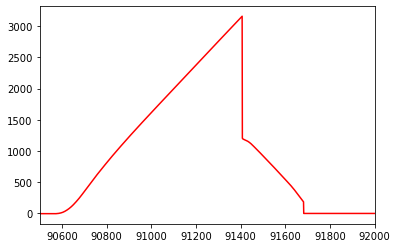

In [161]:
plt.plot(height, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

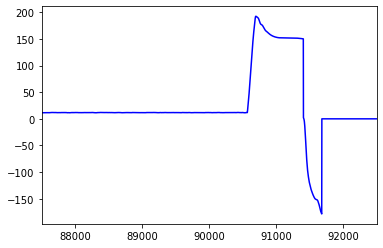

In [157]:
plt.plot(velocity, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

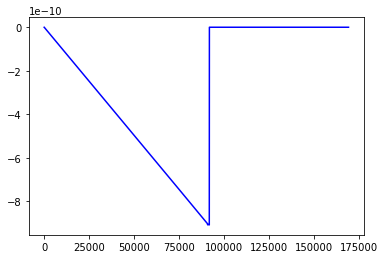

In [132]:
plt.plot(acc_offset, 'b')
plt.show()

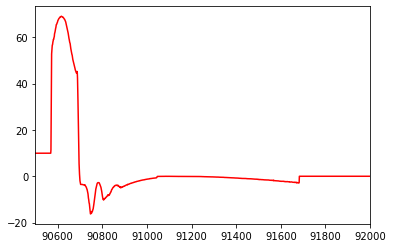

In [162]:
plt.plot(acc, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

In [45]:
max(height)

1539.7056735990482

In [46]:
max(velocity)

141.70815314328473

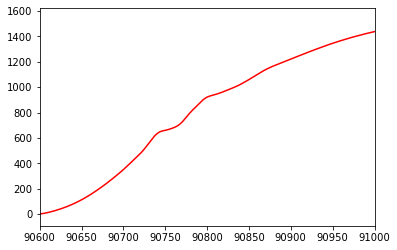

In [41]:
plt.plot(height, 'r')
axes = plt.gca()
axes.set_xlim([90600, 91000])
plt.show()

In [75]:
print(acc[90500])

-0.19


In [5]:
x_bar = np.array([[0],[0],[0]])
print(x_bar[1])

[0]
